In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from dynadojo.wrappers import SystemChecker
import pandas as pd
import os
import sys
sys.path.append("..")
import pickle
from experiments.utils import load_from_json


Run these commands to generate the results:
``` 
python -m experiments make --challenge fc --system lds --algo lr
python -m experiments \
        run \
        --params_file experiments/outputs/fc/lds/fc_lds_lr_l=10/params.json \
        --num_cpu_parallel -2
```


In [2]:
data_folder = "../experiments/outputs/fc/lds/fc_lds_lr_l=10"
df_path = os.path.join(data_folder, "fc_lds_lr_l=10.csv")
params_path = os.path.join(data_folder, "params.json")


In [3]:
# load all data into data frame
df = pd.read_csv(df_path)
experiment_params = load_from_json(params_path) #loads in dictionary duplicate to params.json
row = df.iloc[0] # index of the csv file

In [4]:
latent_dim = int(row["latent_dim"])
embed_dim = int(row["embed_dim"])
n= row["n"]

trials = int(row["trial"])
test_examples = experiment_params["challenge"]["test_examples"]
test_timesteps = experiment_params["challenge"]["test_timesteps"]
# load seed from row
seed = row["system_seed"]
serialized_class = experiment_params["challenge"]["system_cls"]

cls = serialized_class(latent_dim, embed_dim, seed=seed)
system = SystemChecker(cls)

noisy = experiment_params["evaluate"]["noisy"]  #get noisy from params
y0 = system.make_init_conds(test_examples, in_dist=True)
test_set = system.make_data(y0, timesteps=test_timesteps, noisy=noisy)

pickle_path = os.path.join(data_folder, f"intermediate/n={n}_l={latent_dim}_trial={trials}.pickle")
#load pickle file based on row
with open(pickle_path, "rb") as f:
    algo = pickle.load(f)

pred = algo.predict(test_set[:, 0], test_timesteps)
error = system.calc_error(pred, test_set)


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'LDS l=10, e=10 - '}>)

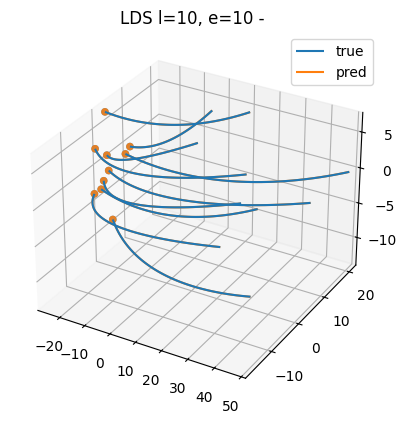

In [5]:
plot_filepath = os.path.join(data_folder, f"intermediate/n={n}_l={latent_dim}_trial={trials}.pdf")
if hasattr(system._system, 'save_plotted_trajectories'):
    cls.save_plotted_trajectories(test_set, pred, plot_filepath, savefig=False)